<a href="https://colab.research.google.com/github/AbooMardiiyah/RPP-News-classification/blob/main/News_classification_rpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## News Classification

* In this project, I observed we have multiple languages in our dataset.so I used a pretrained Multilingual language model 

    `bert-base-multilingual-uncased`
* This model was trained on 104 languages which makes it easier for downstream task

* The news classification is a sequence classification problem which makes our model useful for this problem. 

* Also, for this model, we dont need to drop or remove stop words from our data as this would make us loose context and semantics. This model tries to capture semantice in our data

* i also observed some languages were mislabelled so i dropped them as they hold a lesser percentage of our data. The model can already detect those languages since its a multilingual model

## Training Approach

Due to limited resources on my side ( Ran out of GPU Limit on Colab), i built a classifier by Fine-Tuning the Multilingual model on the provided data and pushed the weights to my [ Hugging-face-repository](https://huggingface.co/Tiamz/bert-base-multilingual-uncased-finetuned-news) ( a hub for language models and datasets)

If youre going to run this notebook, you would need to provide a token to your hugging face hub or turn off `push_to_hub` parameter from the trainer

This way, anybody can use the fine-tuned model for the same task remotely. Normally, we save the weights locally but because it is very large ( almost 1gig) i had to save it remotely.

other approaches that could be tried to improve the performance are:

* Data augmentation
* Training a classifier head on top of bert's initialized model
* Zero-Shot Learning

In [1]:
# Mounting my drive to colab to save my data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [4]:
!pip install utils -q

In [5]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.2 MB/s eta 0:00:00


In [6]:
# hide
from utils import *


# Text Classification

Let's make a directory to save our dataset

In [7]:
!mkdir /content/drive/MyDrive/News_article

mkdir: cannot create directory ‘/content/drive/MyDrive/News_article’: File exists


The below codes unzips the file

In [8]:
!unzip "/content/News_article.zip" -d "//content/drive/MyDrive/News_article"

unzip:  cannot find or open /content/News_article.zip, /content/News_article.zip.zip or /content/News_article.zip.ZIP.


In [9]:
#checking the contents of our folder
!ls /content/drive/MyDrive/News_article

'Test data.xlsx'  'Train data.csv'


Let's define the paths to our datasets

In [10]:
Test_data_dir="/content/drive/MyDrive/News_article/Test data.xlsx"
Train_data_dir="/content/drive/MyDrive/News_article/Train data.csv"

In [11]:
# import some packages for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal=plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

In [12]:
df_train=pd.read_csv(Train_data_dir)
df_test=pd.read_excel(Test_data_dir)
df_train

,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0,Real
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0,Real
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0,Real
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0,Real
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0,Real
...,...,...,...,...,...,...,...,...,...,...,...,...
1595,No Author,2016-10-28T03:13:46.387+03:00,iraqi forces score major gains south of mosul,on today at pm duterte wants foreign troops ...,english,presstv.ir,http://media.presstv.com/photo/20161027/d3bfdb...,state,trump vps plane slides runway new york airport,reply today pm part mother child worship https...,1.0,Real
1596,No Author,2016-10-28T03:13:47.181+03:00,us supreme court justice groped female lawyer ...,reply on july pm russia eu prolongs econo...,english,presstv.ir,http://media.presstv.com/photo/20161028/54a83d...,state,presstvrussia cancels request fuel ships spain,today pm solar winds spur geomagnetic storm ma...,1.0,Real
1597,No Author,2016-10-28T03:45:23.031+03:00,trump vps plane slides off runway at new york ...,reply on today at pm part mother child wo...,english,presstv.ir,http://media.presstv.com/photo/20161026/ef2031...,state,study swift birds fly nonstop months every year,today pm aig quadruples limits terrorism insur...,1.0,Real
1598,No Author,2016-10-26T08:00:00.000+03:00,presstvrussia cancels request to fuel ships in...,on today at pm solar winds spur geomagnetic ...,english,presstv.ir,http://media.presstv.com/photo/20161028/b440d4...,state,yemeni forces fire ballistic missile saudi ara...,windows reply november pm nvidia even admitted...,1.0,Real


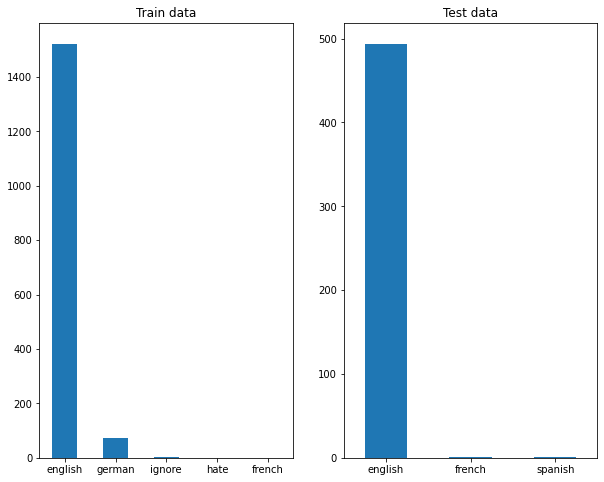

In [13]:
plt.figure(figsize=(10,8))
plt.subplot(121)

df_train.language.value_counts().plot(kind='bar')
plt.xticks(rotation=360)
plt.title('Train data');

plt.subplot(122)
# plt.figure(figsize=(10,8))
df_test.language.value_counts().plot(kind='bar')
plt.xticks(rotation=360)
plt.title('Test data');

From the above Frequency plot, we do not have any language called hate or ignore. Similaryly they do not contain much values so we can just drop them.

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   1599 non-null   object 
 1   published                1600 non-null   object 
 2   title                    1600 non-null   object 
 3   text                     1600 non-null   object 
 4   language                 1599 non-null   object 
 5   site_url                 1599 non-null   object 
 6   main_img_url             1599 non-null   object 
 7   type                     1599 non-null   object 
 8   title_without_stopwords  1597 non-null   object 
 9   text_without_stopwords   1598 non-null   object 
 10  hasImage                 1598 non-null   float64
 11  label                    1599 non-null   object 
dtypes: float64(1), object(11)
memory usage: 150.1+ KB


In [15]:
df_train=df_train.drop_duplicates()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1590 entries, 0 to 1599
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   1589 non-null   object 
 1   published                1590 non-null   object 
 2   title                    1590 non-null   object 
 3   text                     1590 non-null   object 
 4   language                 1589 non-null   object 
 5   site_url                 1589 non-null   object 
 6   main_img_url             1589 non-null   object 
 7   type                     1589 non-null   object 
 8   title_without_stopwords  1587 non-null   object 
 9   text_without_stopwords   1588 non-null   object 
 10  hasImage                 1588 non-null   float64
 11  label                    1589 non-null   object 
dtypes: float64(1), object(11)
memory usage: 161.5+ KB


In [16]:
df_train.shape

(1590, 12)

In [17]:
df_train.isnull().mean()

author                     0.000629
published                  0.000000
title                      0.000000
text                       0.000000
language                   0.000629
site_url                   0.000629
main_img_url               0.000629
type                       0.000629
title_without_stopwords    0.001887
text_without_stopwords     0.001258
hasImage                   0.001258
label                      0.000629
dtype: float64

From above, the percentage of missing values is so small that we can just drop them and also it is hard to fill text values unlike numerical or categorical values that can be filled with statistical measures like mean, mode or predictive models like RandomForest or MissForest

In [18]:
df_train = df_train.dropna() 
df_train.isnull().sum()

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
label                      0
dtype: int64

In [19]:
df_train.shape

(1587, 12)

### Let's check the Test dataset too

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   497 non-null    object 
 1   published                497 non-null    object 
 2   title                    497 non-null    object 
 3   text                     451 non-null    object 
 4   language                 496 non-null    object 
 5   site_url                 496 non-null    object 
 6   main_img_url             496 non-null    object 
 7   type                     496 non-null    object 
 8   title_without_stopwords  496 non-null    object 
 9   text_without_stopwords   447 non-null    object 
 10  hasImage                 496 non-null    float64
dtypes: float64(1), object(10)
memory usage: 42.8+ KB


In [21]:
df_test=df_test.drop_duplicates()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 496
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   497 non-null    object 
 1   published                497 non-null    object 
 2   title                    497 non-null    object 
 3   text                     451 non-null    object 
 4   language                 496 non-null    object 
 5   site_url                 496 non-null    object 
 6   main_img_url             496 non-null    object 
 7   type                     496 non-null    object 
 8   title_without_stopwords  496 non-null    object 
 9   text_without_stopwords   447 non-null    object 
 10  hasImage                 496 non-null    float64
dtypes: float64(1), object(10)
memory usage: 46.6+ KB


In [22]:
df_test.isnull().mean()

author                     0.000000
published                  0.000000
title                      0.000000
text                       0.092555
language                   0.002012
site_url                   0.002012
main_img_url               0.002012
type                       0.002012
title_without_stopwords    0.002012
text_without_stopwords     0.100604
hasImage                   0.002012
dtype: float64

In [23]:
df_test = df_test.dropna() 
df_test.isnull().sum()

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
dtype: int64

In [24]:
df_test.shape

(447, 11)

In [25]:
df_train = df_train[(df_train['language'] != 'ignore') & (df_train['language'] != 'hate') ]
df_train.language.value_counts()

english    1511
german       72
french        1
Name: language, dtype: int64

In [26]:
df_test.language.value_counts()

english    445
french       1
spanish      1
Name: language, dtype: int64

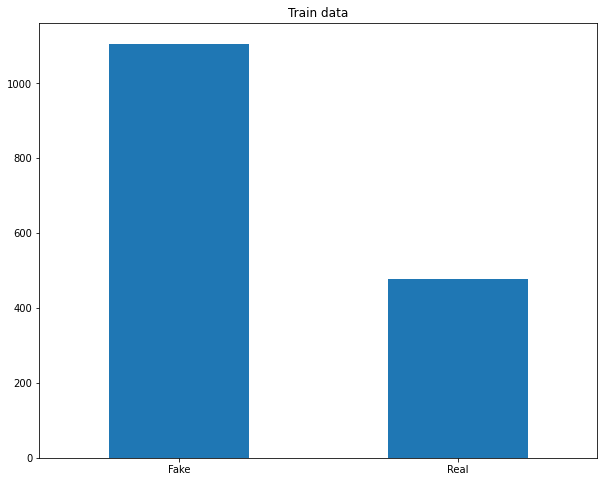

In [27]:
plt.figure(figsize=(10,8))
df_train.label.value_counts().plot(kind='bar')
plt.xticks(rotation=360)
plt.title('Train data');


In [28]:
# Split the DataFrame into training and validation sets
from sklearn.model_selection import train_test_split
df_train= df_train.sample(frac=1, random_state=0)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=0)


In [29]:
df_train.columns

Index(['author', 'published', 'title', 'text', 'language', 'site_url',
       'main_img_url', 'type', 'title_without_stopwords',
       'text_without_stopwords', 'hasImage', 'label'],
      dtype='object')

In [30]:
df_train['label']=df_train['label'].replace({'Real':1,'Fake':0})
df_train.label

728     1
661     0
1462    1
1128    1
939     0
       ..
1039    1
356     0
545     0
1005    0
1316    0
Name: label, Length: 1267, dtype: int64

In [31]:
df_val['label']=df_val['label'].replace({'Real':1,'Fake':0})
df_val.label

227     0
1415    1
6       1
932     0
906     0
1428    1
181     0
1406    1
280     0
812     0
737     1
522     0
422     0
590     0
134     0
1323    0
479     0
958     0
354     0
149     0
1239    0
1542    1
986     0
1374    0
1294    0
1211    0
1043    1
57      0
217     0
476     0
136     0
782     1
756     1
428     0
1150    0
345     0
69      0
1264    0
1400    1
315     0
1420    1
651     0
1303    0
1086    1
86      0
777     1
1590    1
791     1
744     1
1090    1
842     1
1268    0
709     0
1484    1
389     0
888     0
1449    1
80      0
1251    0
1104    1
1429    1
1289    0
836     1
964     0
240     0
1527    1
1461    1
320     0
1116    1
934     0
1064    1
954     0
1514    1
929     0
225     0
665     0
1180    0
128     0
1033    0
1297    0
1459    1
1185    0
361     0
972     0
259     0
1136    1
1032    0
1352    0
399     0
1537    1
1047    1
234     0
676     0
732     1
1480    1
1396    1
252     0
769     1
1074    1
1379    0


In [32]:
from datasets import Dataset, DatasetDict

In [33]:
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)




In [34]:
train_ds=train_ds.remove_columns(['author', 'published', 'title',  'language', 'site_url', 'main_img_url', 'type', 'title_without_stopwords', 'text_without_stopwords', 'hasImage', '__index_level_0__'])
val_ds=val_ds.remove_columns(['author', 'published', 'title',  'language', 'site_url', 'main_img_url', 'type', 'title_without_stopwords', 'text_without_stopwords', 'hasImage', '__index_level_0__'])


In [35]:
test_ds

Dataset({
    features: ['author', 'published', 'title', 'text', 'language', 'site_url', 'main_img_url', 'type', 'title_without_stopwords', 'text_without_stopwords', 'hasImage', '__index_level_0__'],
    num_rows: 447
})

In [36]:
test_ds=test_ds.remove_columns(['author', 'published', 'title',  'language', 'site_url', 'main_img_url', 'type', 'title_without_stopwords', 'text_without_stopwords', 'hasImage','__index_level_0__'])

In [37]:
test_ds

Dataset({
    features: ['text'],
    num_rows: 447
})

In [38]:
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 1267
})

In [39]:
ds = DatasetDict()

ds['train'] = train_ds
ds['validation'] = val_ds
ds['test']=test_ds

In [40]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1267
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 317
    })
    test: Dataset({
        features: ['text'],
        num_rows: 447
    })
})

### How Long Are Our Texts?

Transformer models have a maximum input sequence length that is referred to as the _maximum context size_. For applications using `bert-base-multilingual-uncased`, the maximum context size is 512 tokens, which amounts to a few paragraphs of text. 

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


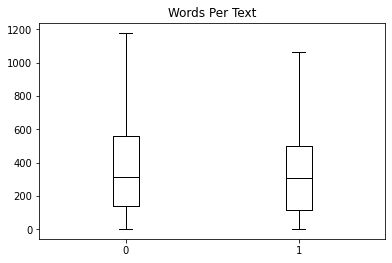

In [41]:
df_train["Words Per Text"] = df_train["text"].str.split().apply(len)
df_train.boxplot("Words Per Text", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show();

From the plot we see that for each category of our label, most texts are around 300 words long and the longest texts are well below Bert's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue. 

In [42]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.3 MB/s eta 0:00:00


In [43]:
from transformers import BertTokenizer, BasicTokenizer
from transformers import BertModel, BertPreTrainedModel, BertForSequenceClassification


model_ckpt = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_ckpt)

In [44]:
tokenizer.vocab_size

105879

and the corresponding model's maximum context size:

In [45]:
tokenizer.model_max_length

512

Another interesting attribute to know about is the names of the fields that the model expects in its forward pass:

In [46]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

### Tokenizing the Whole Dataset

In [47]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [48]:
ds['test'].features

{'text': Value(dtype='string', id=None)}

This function applies the tokenizer to a batch of examples; `padding=True` will pad the examples with zeros to the size of the longest one in a batch, and `truncation=True` will truncate the examples to the model's maximum context size. To see `tokenize()` in action, let's pass a batch of two examples from the training set:

In [49]:
print(tokenize(ds["train"][35]))

{'input_ids': [101, 10103, 67456, 24949, 38485, 10110, 15450, 10262, 88463, 23719, 11655, 13689, 10107, 11753, 33426, 10114, 22078, 10107, 67456, 24949, 21470, 10110, 19428, 11122, 11411, 17603, 24560, 10127, 143, 24497, 11552, 10629, 18328, 10160, 10103, 10904, 36129, 78985, 17826, 11473, 90680, 42344, 28290, 10104, 26813, 10203, 20063, 10459, 28634, 11608, 47002, 10870, 13689, 46667, 10785, 17301, 31380, 10110, 58997, 10190, 10115, 10114, 25045, 18328, 42344, 13689, 10107, 30453, 50892, 10107, 59399, 10563, 27585, 31520, 10150, 25577, 10112, 11811, 10578, 10247, 10497, 16222, 42344, 10362, 10104, 10103, 18281, 10108, 15720, 12349, 10469, 69917, 10125, 10103, 21903, 10652, 10578, 10320, 58815, 10107, 10578, 10247, 22078, 10107, 10889, 36789, 20332, 11359, 10320, 67456, 24949, 38485, 80865, 10107, 19428, 11122, 10488, 11868, 143, 17348, 18174, 10110, 77848, 15982, 10110, 44054, 20319, 10104, 10203, 17348, 72537, 10323, 93970, 33190, 10127, 10203, 11260, 15239, 39537, 15440, 23719, 2219

In [50]:
print(tokenize(ds["train"][2]))

{'input_ids': [101, 10763, 10816, 75753, 74146, 24596, 22430, 19738, 45107, 44887, 14790, 21630, 27875, 12948, 10104, 10372, 81872, 15227, 10125, 10333, 10144, 74146, 17622, 32691, 12878, 10114, 143, 11585, 10108, 10763, 37180, 10111, 28376, 88028, 10104, 19225, 26188, 10151, 10513, 10373, 10103, 18099, 10108, 10763, 12953, 10104, 19021, 10438, 60778, 10144, 24978, 10765, 10103, 16769, 11901, 10108, 10772, 10948, 74146, 70342, 11371, 11847, 10110, 12171, 10104, 10144, 84246, 27711, 10499, 10619, 10469, 54263, 12338, 24989, 10203, 10103, 84246, 27711, 10499, 10125, 10103, 11380, 10108, 10920, 10311, 43310, 55149, 12125, 16751, 10103, 12968, 10575, 10108, 12837, 63088, 10125, 63585, 11008, 10346, 50528, 10163, 10916, 73266, 22182, 10342, 54838, 10114, 10346, 72302, 10104, 10103, 33740, 10502, 10103, 12953, 10456, 17982, 22830, 12319, 10195, 18248, 31305, 10110, 11723, 10139, 14743, 10195, 143, 10763, 14264, 10359, 12174, 70342, 11371, 12171, 14281, 10144, 19026, 24978, 10438, 29956, 1020

In [51]:
#hide_input
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


Also note that in addition to returning the encoded texts as `input_ids`, the tokenizer returns a list of `attention_mask` arrays. This is because we do not want the model to get confused by the additional padding tokens: the attention mask allows the model to ignore the padded parts of the input.


In [52]:
# hide_output
ds_encoded = ds.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

By default, the `map()` method operates individually on every example in the corpus, so setting `batched=True` will encode the texts in batches. Because we've set `batch_size=None`, our `tokenize()` function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new `input_ids` and `attention_mask` columns to the dataset:

In [53]:
print(ds_encoded["train"].column_names)

['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask']


### Fine-Tuning Transformers


Let's now explore what it takes to fine-tune a transformer end-to-end. With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them. This requires the classification head to be differentiable, which is why this method usually uses a neural network for classification.


Training the hidden states that serve as inputs to the classification model will help us avoid the problem of working with data that may not be well suited for the classification task. Instead, the initial hidden states adapt during training to decrease the model loss and thus increase its performance.

We'll be using the `Trainer` API Transformers to simplify the training loop. Let's look at the ingredients we need to set one up!

#### Loading a pretrained model

The first thing we need is a pretrained `bert-base-multilingual-uncased`. The only slight modification is that we use the `AutoModelForSequenceClassification` model instead of `AutoModel`. The difference is that the `AutoModelForSequenceClassification` model has a classification head on top of the pretrained model outputs, which can be easily trained with the base model. We just need to specify how many labels the model has to predict (two in our case), since this dictates the number of outputs the classification head has:

In [54]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
# target_names = list(set(data["en"]["train"]["labels"]))
# label2idx = {label: idx for idx, label in enumerate(target_names)}
# print(label2idx)

In [56]:
# hide_output
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

You will see a warning that some parts of the model are randomly initialized. This is normal since the classification head has not yet been trained. The next step is to define the metrics that we'll use to evaluate our model's performance during fine-tuning.

## Defining the performance metrics


* $F_1$-score and $Accuracy$ 

To monitor metrics during training, we need to define a `compute_metrics()` function for the `Trainer`.  This function receives an `EvalPrediction` object (which is a named tuple with `predictions` and `label_ids` attributes) and needs to return a dictionary that maps each metric's name to its value. For our application, we'll compute the $F_1$-score and the $accuracy$ of the model as follows:

In [57]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

With the dataset and metrics ready, we just have two final things to take care of before we define the `Trainer` class:

1. Log in to our account on the Hugging Face Hub. This will allow us to push our fine-tuned model to our account on the Hub and share it with the community.
2. Define all the hyperparameters for the training run.



#### Training the model

If your trying to run this code, you will need to provide an access token from your hugging face account

In [58]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [62]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(ds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-news"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

Here we also set the batch size, learning rate, and number of epochs, and specify to load the best model at the end of the training run. With this final ingredient, we can instantiate and fine-tune our model with the `Trainer`: 

In [63]:
%%time
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/Tiamz/bert-base-multilingual-uncased-finetuned-news into local empty directory.


Download file pytorch_model.bin:   0%|          | 15.4k/638M [00:00<?, ?B/s]

Download file runs/Feb02_13-05-15_3c79f1686683/events.out.tfevents.1675343193.3c79f1686683.628.0: 100%|#######…

Download file training_args.bin: 100%|##########| 3.50k/3.50k [00:00<?, ?B/s]

Download file runs/Feb02_13-05-15_3c79f1686683/1675343193.8049996/events.out.tfevents.1675343193.3c79f1686683.…

Clean file runs/Feb02_13-05-15_3c79f1686683/events.out.tfevents.1675343193.3c79f1686683.628.0:  15%|#4        …

Clean file training_args.bin:  29%|##8       | 1.00k/3.50k [00:00<?, ?B/s]

Clean file runs/Feb02_13-05-15_3c79f1686683/1675343193.8049996/events.out.tfevents.1675343193.3c79f1686683.628…

Clean file pytorch_model.bin:   0%|          | 1.00k/638M [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.570200,0.515636,0.744479,0.755313
2,0.338400,0.288309,0.861199,0.864060
3,0.204500,0.369918,0.899054,0.897700
4,0.117700,0.517229,0.895899,0.896938
5,0.046500,0.570490,0.889590,0.890394


CPU times: user 10min 50s, sys: 1min 12s, total: 12min 3s
Wall time: 15min 22s


TrainOutput(global_step=795, training_loss=0.2538631370279399, metrics={'train_runtime': 772.0906, 'train_samples_per_second': 8.205, 'train_steps_per_second': 1.03, 'total_flos': 1666808535705600.0, 'train_loss': 0.2538631370279399, 'epoch': 5.0})

In [64]:
# hide_output
preds_output = trainer.predict(ds_encoded["validation"])

The output of the `predict()` method is a `PredictionOutput` object that contains arrays of `predictions` and `label_ids`, along with the metrics we passed to the trainer. For example, the metrics on the validation set can be accessed as follows:

In [65]:
preds_output.metrics

{'test_loss': 0.5704898834228516,
 'test_accuracy': 0.889589905362776,
 'test_f1': 0.8903941803698263,
 'test_runtime': 11.0948,
 'test_samples_per_second': 28.572,
 'test_steps_per_second': 3.605}

## Error analysis

Before moving on, we should investigate our model's predictions a little bit further. A simple yet powerful technique is to sort the validation samples by the model loss. When we pass the label during the forward pass, the loss is automatically calculated and returned. Here's a function that returns the loss along with the predicted label:

In [66]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [67]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1267
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 317
    })
    test: Dataset({
        features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 447
    })
})

In [68]:
val_ds=ds_encoded['validation']

In [69]:
val_ds.set_format("torch",
                            columns=["input_ids", "attention_mask","token_type_ids", "label"])

In [70]:
val_ds

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 317
})

In [71]:
# hide_output
# Convert our dataset back to PyTorch tensors
# Compute loss values
val_ds = val_ds.map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/20 [00:00<?, ?ba/s]

Finally, we create a `DataFrame` with the texts, losses, and predicted/true labels:

In [72]:
val_ds

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 317
})

In [73]:
val_ds.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_val = val_ds[:][cols]
val_ds.reset_format()


In [74]:
df_val['label']=df_val['label'].map({1:'Real',0:'Fake'})
df_val['predicted_label']=df_val['predicted_label'].map({1:'Real',0:'Fake'})


In [77]:
df_val.head()

,text,label,predicted_label,loss
0,by brandon turbeville antifluoridation activis...,Fake,Fake,0.001191
1,by jason easley on sun oct th at pm fox news...,Real,Real,0.001964
2,breaking nypd ready to make arrests in weiner ...,Real,Fake,6.578652
3,home news watch video leaked from obamas c...,Fake,Fake,0.001067
4,arrested at protest of the dakota access pipe...,Fake,Fake,0.001387


In [78]:
#hide_output
df_val.sort_values("loss", ascending=True).head(5)

,text,label,predicted_label,loss
306,keywords acupuncture baby eczema cure baby e...,Fake,Fake,0.000910
238,foods that naturally unclog arteries and prev...,Fake,Fake,0.000919
254,keywords cavities coconut oil dental health ...,Fake,Fake,0.000923
173,fight inflammation with these vitamins and mi...,Fake,Fake,0.000929
190,how to remove uric acid crystallization in joi...,Fake,Fake,0.000930


## Predictions on Test data provided

In [79]:
test_ds=ds_encoded['test']
test_ds

Dataset({
    features: ['text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 447
})

In [80]:
test_ds.set_format("torch",
                            columns=["input_ids", "attention_mask","token_type_ids"])

In [81]:
def forward_pass_for_test(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)

    # Place outputs on CPU for compatibility with other dataset columns   
    return {"predicted_label": pred_label.cpu().numpy()}

In [82]:
test_ds = test_ds.map(
    forward_pass_for_test, batched=True, batch_size=16)

  0%|          | 0/28 [00:00<?, ?ba/s]

In [83]:
test_ds

Dataset({
    features: ['text', 'input_ids', 'token_type_ids', 'attention_mask', 'predicted_label'],
    num_rows: 447
})

### Original Data given

In [84]:
df_test[:5]

,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage
0,No Author,2016-10-28T04:22:01.276+03:00,yemeni forces fire ballistic missile at saudi ...,re windows reply on november pm nvidia ...,english,presstv.ir,http://media.presstv.com/photo/20161028/e40abc...,state,massive marine park declared antarctic ocean,largest public pensions face trillion hole rep...,1.0
1,No Author,2016-10-28T04:22:07.575+03:00,fastest electric commuter ferry unveiled in sw...,logged the answer to is i am one of the peopl...,english,presstv.ir,http://media.presstv.com/photo/20161028/fb09c4...,state,comprehensive international resolve key terror...,author topic obsolete read times members guest...,1.0
2,No Author,2016-10-28T18:02:37.152+03:00,massive marine park declared in antarctic ocean,re largest public pensions face trillion hole...,english,presstv.ir,http://media.presstv.com/photo/20161028/d8fad9...,state,many instances voter fraud gop vp candidate pence,today pm lines profit misses estimates ads pus...,1.0
3,No Author,2016-10-28T18:02:37.902+03:00,comprehensive international resolve key to ter...,author topic obsolete read times members an...,english,presstv.ir,http://media.presstv.com/photo/20161028/b28af3...,state,five filipino hostages freed somali pirates re...,today pm nintendo cuts fullyear sales operatin...,1.0
4,No Author,2016-10-28T18:02:38.498+03:00,there are many instances of voter fraud gop vp...,on today at pm lines profit misses estimates...,english,presstv.ir,http://media.presstv.com/photo/20161028/449bd2...,state,palestinian homes razed occupied w banks area c,reply april pm fukushima disaster caused least...,1.0


Now, let's update the test dataset with our predictions

In [85]:
test_df=df_test.copy()

In [86]:
test_ds.set_format("pandas")
cols = ["text", "predicted_label"]
test_df= test_ds[:][cols]

In [87]:
test_df['predicted_label']=test_df['predicted_label'].map({1:'Real',0:'Fake'})


In [88]:
df_test['label']=test_df['predicted_label']
df_test.head()

,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
0,No Author,2016-10-28T04:22:01.276+03:00,yemeni forces fire ballistic missile at saudi ...,re windows reply on november pm nvidia ...,english,presstv.ir,http://media.presstv.com/photo/20161028/e40abc...,state,massive marine park declared antarctic ocean,largest public pensions face trillion hole rep...,1.0,Fake
1,No Author,2016-10-28T04:22:07.575+03:00,fastest electric commuter ferry unveiled in sw...,logged the answer to is i am one of the peopl...,english,presstv.ir,http://media.presstv.com/photo/20161028/fb09c4...,state,comprehensive international resolve key terror...,author topic obsolete read times members guest...,1.0,Fake
2,No Author,2016-10-28T18:02:37.152+03:00,massive marine park declared in antarctic ocean,re largest public pensions face trillion hole...,english,presstv.ir,http://media.presstv.com/photo/20161028/d8fad9...,state,many instances voter fraud gop vp candidate pence,today pm lines profit misses estimates ads pus...,1.0,Fake
3,No Author,2016-10-28T18:02:37.902+03:00,comprehensive international resolve key to ter...,author topic obsolete read times members an...,english,presstv.ir,http://media.presstv.com/photo/20161028/b28af3...,state,five filipino hostages freed somali pirates re...,today pm nintendo cuts fullyear sales operatin...,1.0,Fake
4,No Author,2016-10-28T18:02:38.498+03:00,there are many instances of voter fraud gop vp...,on today at pm lines profit misses estimates...,english,presstv.ir,http://media.presstv.com/photo/20161028/449bd2...,state,palestinian homes razed occupied w banks area c,reply april pm fukushima disaster caused least...,1.0,Real


In [89]:
df_test.to_csv("updated_test_data_with_predictions.csv")

In [90]:
# #hide_output
trainer.push_to_hub(commit_message="Training completed!")

Upload file pytorch_model.bin:   0%|          | 32.0k/638M [00:00<?, ?B/s]

Upload file runs/Feb02_15-20-15_a7380c7f7d0b/events.out.tfevents.1675351370.a7380c7f7d0b.219.0: 100%|#########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Tiamz/bert-base-multilingual-uncased-finetuned-news
   14fbeb2..ff11144  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Tiamz/bert-base-multilingual-uncased-finetuned-news
   14fbeb2..ff11144  main -> main

To https://huggingface.co/Tiamz/bert-base-multilingual-uncased-finetuned-news
   ff11144..db85be3  main -> main

   ff11144..db85be3  main -> main



'https://huggingface.co/Tiamz/bert-base-multilingual-uncased-finetuned-news/commit/ff1114445589f150141aa3e9fb7dfbb0ffc202a0'

We can also use the fine-tuned model to make predictions on new News article. Since we've pushed our model to the Hub, we can now use it with the `pipeline()` function, just like we did above.